In [168]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

# using Optim 
using Plots
using TimerOutputs
using StatsBase
using SparseArrays
using Plots
using Parameters
using LinearAlgebra

# include("src/AON_hyperlouvain.jl")

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


In [15]:
function detectabilityData(n, cᵢ, cₒ; allow_degenerate=true)
    """
    n should be even
    """
    n_group = n ÷ 2
    
    mᵢ = cᵢ*n/3
    mₒ = cₒ*n/2
    
    E = Dict(k => Dict() for k ∈ 1:3)
    
    for i ∈ 1:mₒ
        s = rand(1:n_group)
        t = rand(1:n_group) + n_group
        E[2][[s,t]] = get(E[2], [s,t], 0) + 1
    end
    
    for i ∈ 1:mᵢ
        s, t, v = sort(rand(1:n_group, 3) .+ (rand()<0.5 ? n_group : 0))
        if allow_degenerate
            E[3][[s, t, v]] = get(E[3], [s,t, v], 0) + 1
        else
            while length(unique([s, t, v])) < 3
                s, t, v = sort(rand(1:n_group, 3) .+ (rand()<0.5 ? n_group : 0))
            end
            E[3][[s, t, v]] = get(E[3], [s,t, v], 0) + 1
        end
    end
    
    H = hypergraph(N = 1:n, E = E)
    HypergraphModularity.computeDegrees!(H)
    return(H)
end

detectabilityData (generic function with 1 method)

In [274]:
function percent_identified(Z, Ẑ)
    d = Dict()
    for i = 1:length(Z)
        d[(Z[i], Ẑ[i])] = get(d, (Z[i], Ẑ[i]), 0) + 1
    end
    if length(unique(Ẑ)) > 1
        return 2*maximum(values(d)) / length(Z)
    else
        return 0
    end
end

percent_identified (generic function with 1 method)

In [275]:
function detectabilityExperiment(n, cᵢ, cₒ; n_rounds = 10)
    
    kmax = 3
    
    function ω(p,α)
        k = p[2]
        δ = p[1]
        return ((1+(1-δ))*n)^α[k] / (n^α[k + kmax])
    end

    Ω = allOrNothingIntensityFunction(ω, kmax);
    
    Z = vcat(repeat([1], n÷2), repeat([2], n÷2))
    H = detectabilityData(n, cᵢ, cₒ; allow_degenerate=false)
    
    # each triangle attached to a node becomes 2 dyadic 
    # edges attached to that node (plus one more dyadic edge) 
    # not attached to that node
    ĉᵢ, ĉₒ = 2cᵢ, cₒ  
    
    c = (ĉᵢ - ĉₒ)/sqrt(2(ĉᵢ + ĉₒ))
    
    Z_ = copy(Z)
    
    best_L = -Inf
    best_identified = 0
    
    weighted=false
    
    for i in 1:n_rounds
        
        # using the true partition!! at least to start
        γ̂ = computeDyadicResolutionParameter(H, Z_)
        Z_ = CliqueExpansionModularity(H, γ̂, weighted, true, false)
        
        ω_in, ω_out = computeDyadicResolutionParameter(H, Z_; mode="ω", weighted=weighted)
        L_D = dyadicLogLikelihood(H, Z_, ω_in, ω_out; weighted=weighted)

        if L_D > best_L
            best_L = L_D
            best_identified = mutualInformation(Z, Z_, true)
        end
    end
    
    best_dyadic_score = best_identified
    
    Z_ = copy(Z)

    best_L = -Inf
    best_identified = 0
    
    α0 = zeros(2*kmax)
    α̂ = α0
    
    for i in 1:n_rounds
        α̂ = learnParameters(H, Z_, Ω, α̂; n_iters = 100, amin = 10^(-10), amax = 100)
        
        cut_weights, vol_weights, e2n, n2e,w,d,elen = AON_Inputs(H,ω,α̂,kmax);
        
        Zs_ = SuperNode_PPLouvain(n2e,e2n,w,d,elen,cut_weights,vol_weights,kmax,true, 100, false);
        Z_ = Zs_[:,end]
        L_H = modularity(H, Z_, Ω; α = α̂)
        
        if L_H > best_L
            best_L = L_H
            best_identified = mutualInformation(Z, Z_,true)
        end
    end
    
    best_hypergraph_score = best_identified
    
    return(c, best_dyadic_score, best_hypergraph_score)
end

detectabilityExperiment (generic function with 1 method)

In [282]:
Cᵢ, Cₒ = zeros(0), zeros(0)
C, D, H = zeros(0), zeros(0), zeros(0)

for cₒ ∈ [2, 5], cᵢ ∈ 0:.2:4cₒ, k ∈ 1:5
    c, d, h = detectabilityExperiment(500, cᵢ, cₒ)
    
    append!(Cᵢ, cᵢ)
    append!(Cₒ, cₒ)
    append!(C,  c)
    append!(D,  d)
    append!(H,  h)
end

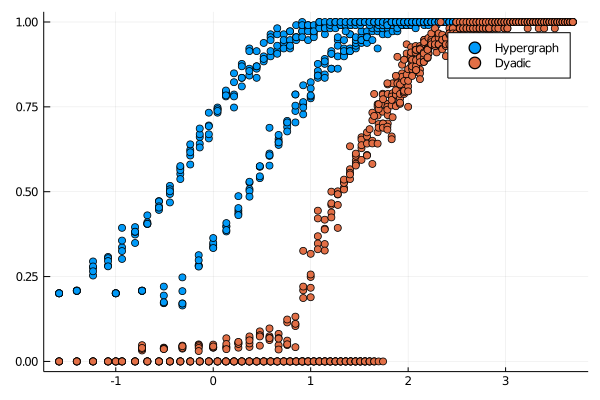

In [283]:
plot(C, H, seriestype  = :scatter, label = "Hypergraph")
plot!(C, D, seriestype = :scatter, label = "Dyadic")

In [339]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 450, :height => 200))
R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


┌ Warning: RCall.jl: `summarise()` regrouping output by 'C_i', 'C_o' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


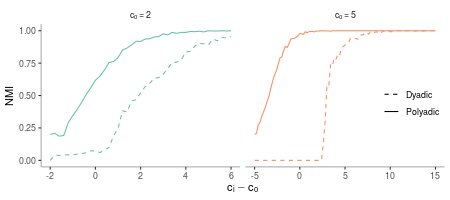

RObject{VecSxp}


In [340]:
R"""
df <- tibble(C_i = $Cᵢ, C_o = $Cₒ, C = $C, D = $D, H = $H) %>% 
    gather(key = method, value = NMI, -C_i, -C_o, -C) %>% 
    group_by(C_i, C_o, method) %>% 
    summarise(NMI = mean(NMI)) %>% 
    mutate(method = ifelse(method == "D", "Dyadic", "Polyadic"))

header = function(x){
    paste("cₒ =", x)
}

df %>% 
    ggplot() + 
    geom_line(aes(x = C_i - C_o, 
        y = NMI, 
        linetype = method, 
        group = paste0(method, C_o),
        color = as.character(C_o))) +
    facet_wrap(~C_o, scales = "free_x",
               labeller = labeller(C_o = header)) + 
    theme_classic() + 
    theme(panel.border = element_blank(),
          axis.line = element_line(color = 'darkgrey'),
          panel.grid.minor = element_blank(),
          legend.position = c(1.0, .65),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6),
          legend.title = element_blank(),
          strip.background = element_blank()) + 
    scale_color_brewer(palette = "Set2") + 
    scale_fill_brewer(palette = "Set2") + 
    xlab(expression(cᵢ - cₒ)) + 
    guides(color = FALSE) + 
    scale_linetype_manual(values=c("dashed", "solid"))
"""

In [341]:
R"""
ggsave("fig/detectability.png", width = 9, height = 3.7)
"""

RObject{NilSxp}
NULL
